In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.utils import resample
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization,MaxPooling2D,Flatten

from sklearn.metrics import f1_score, precision_score, recall_score
from keras.layers import Conv2D,Dense,Dropout,GlobalAveragePooling2D,MaxPool2D
import os
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

2024-06-19 06:28:16.440835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 06:28:16.440957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 06:28:16.637140: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path = '/kaggle/input/chest-xray-pneumonia/chest_xray'
print(os.listdir(path))

['chest_xray', '__MACOSX', 'val', 'test', 'train']


# **Imbalanced Training set**


In [5]:
count_pneu_train = len(os.listdir(path+'/train/PNEUMONIA'))
count_norm_train = len(os.listdir(path+'/train/NORMAL'))
print("Training data:")
print('Pneumonia', count_pneu_train)
print('Normal', count_norm_train, '\n')

count_pneu_test = len(os.listdir(path+'/test/PNEUMONIA'))
count_norm_test = len(os.listdir(path+'/test/NORMAL'))
print("Test data:")
print('Pneumonia', count_pneu_test)
print('Normal', count_norm_test, '\n')

count_pneu_val = len(os.listdir(path+'/val/PNEUMONIA'))
count_norm_val = len(os.listdir(path+'/val/NORMAL'))
print("Validation data:")
print('Pneumonia', count_pneu_val)
print('Normal', count_norm_val)

Training data:
Pneumonia 3875
Normal 1341 

Test data:
Pneumonia 390
Normal 234 

Validation data:
Pneumonia 8
Normal 8


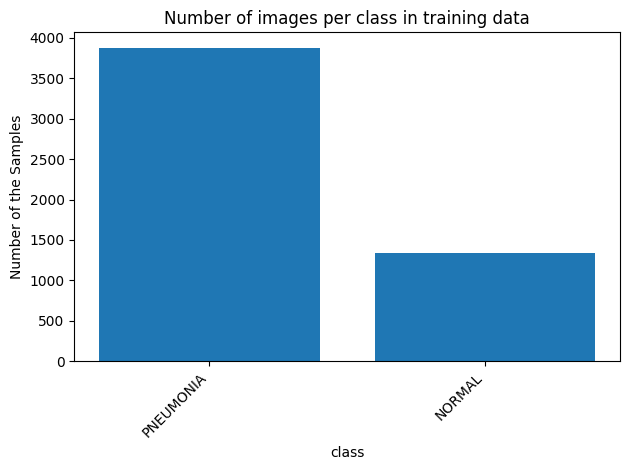

In [9]:
plt.bar(['PNEUMONIA','NORMAL'], [count_pneu_train, count_norm_train], width=0.8)
plt.xlabel('class')
plt.ylabel('Number of the Samples')
plt.title("Number of images per class in training data")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

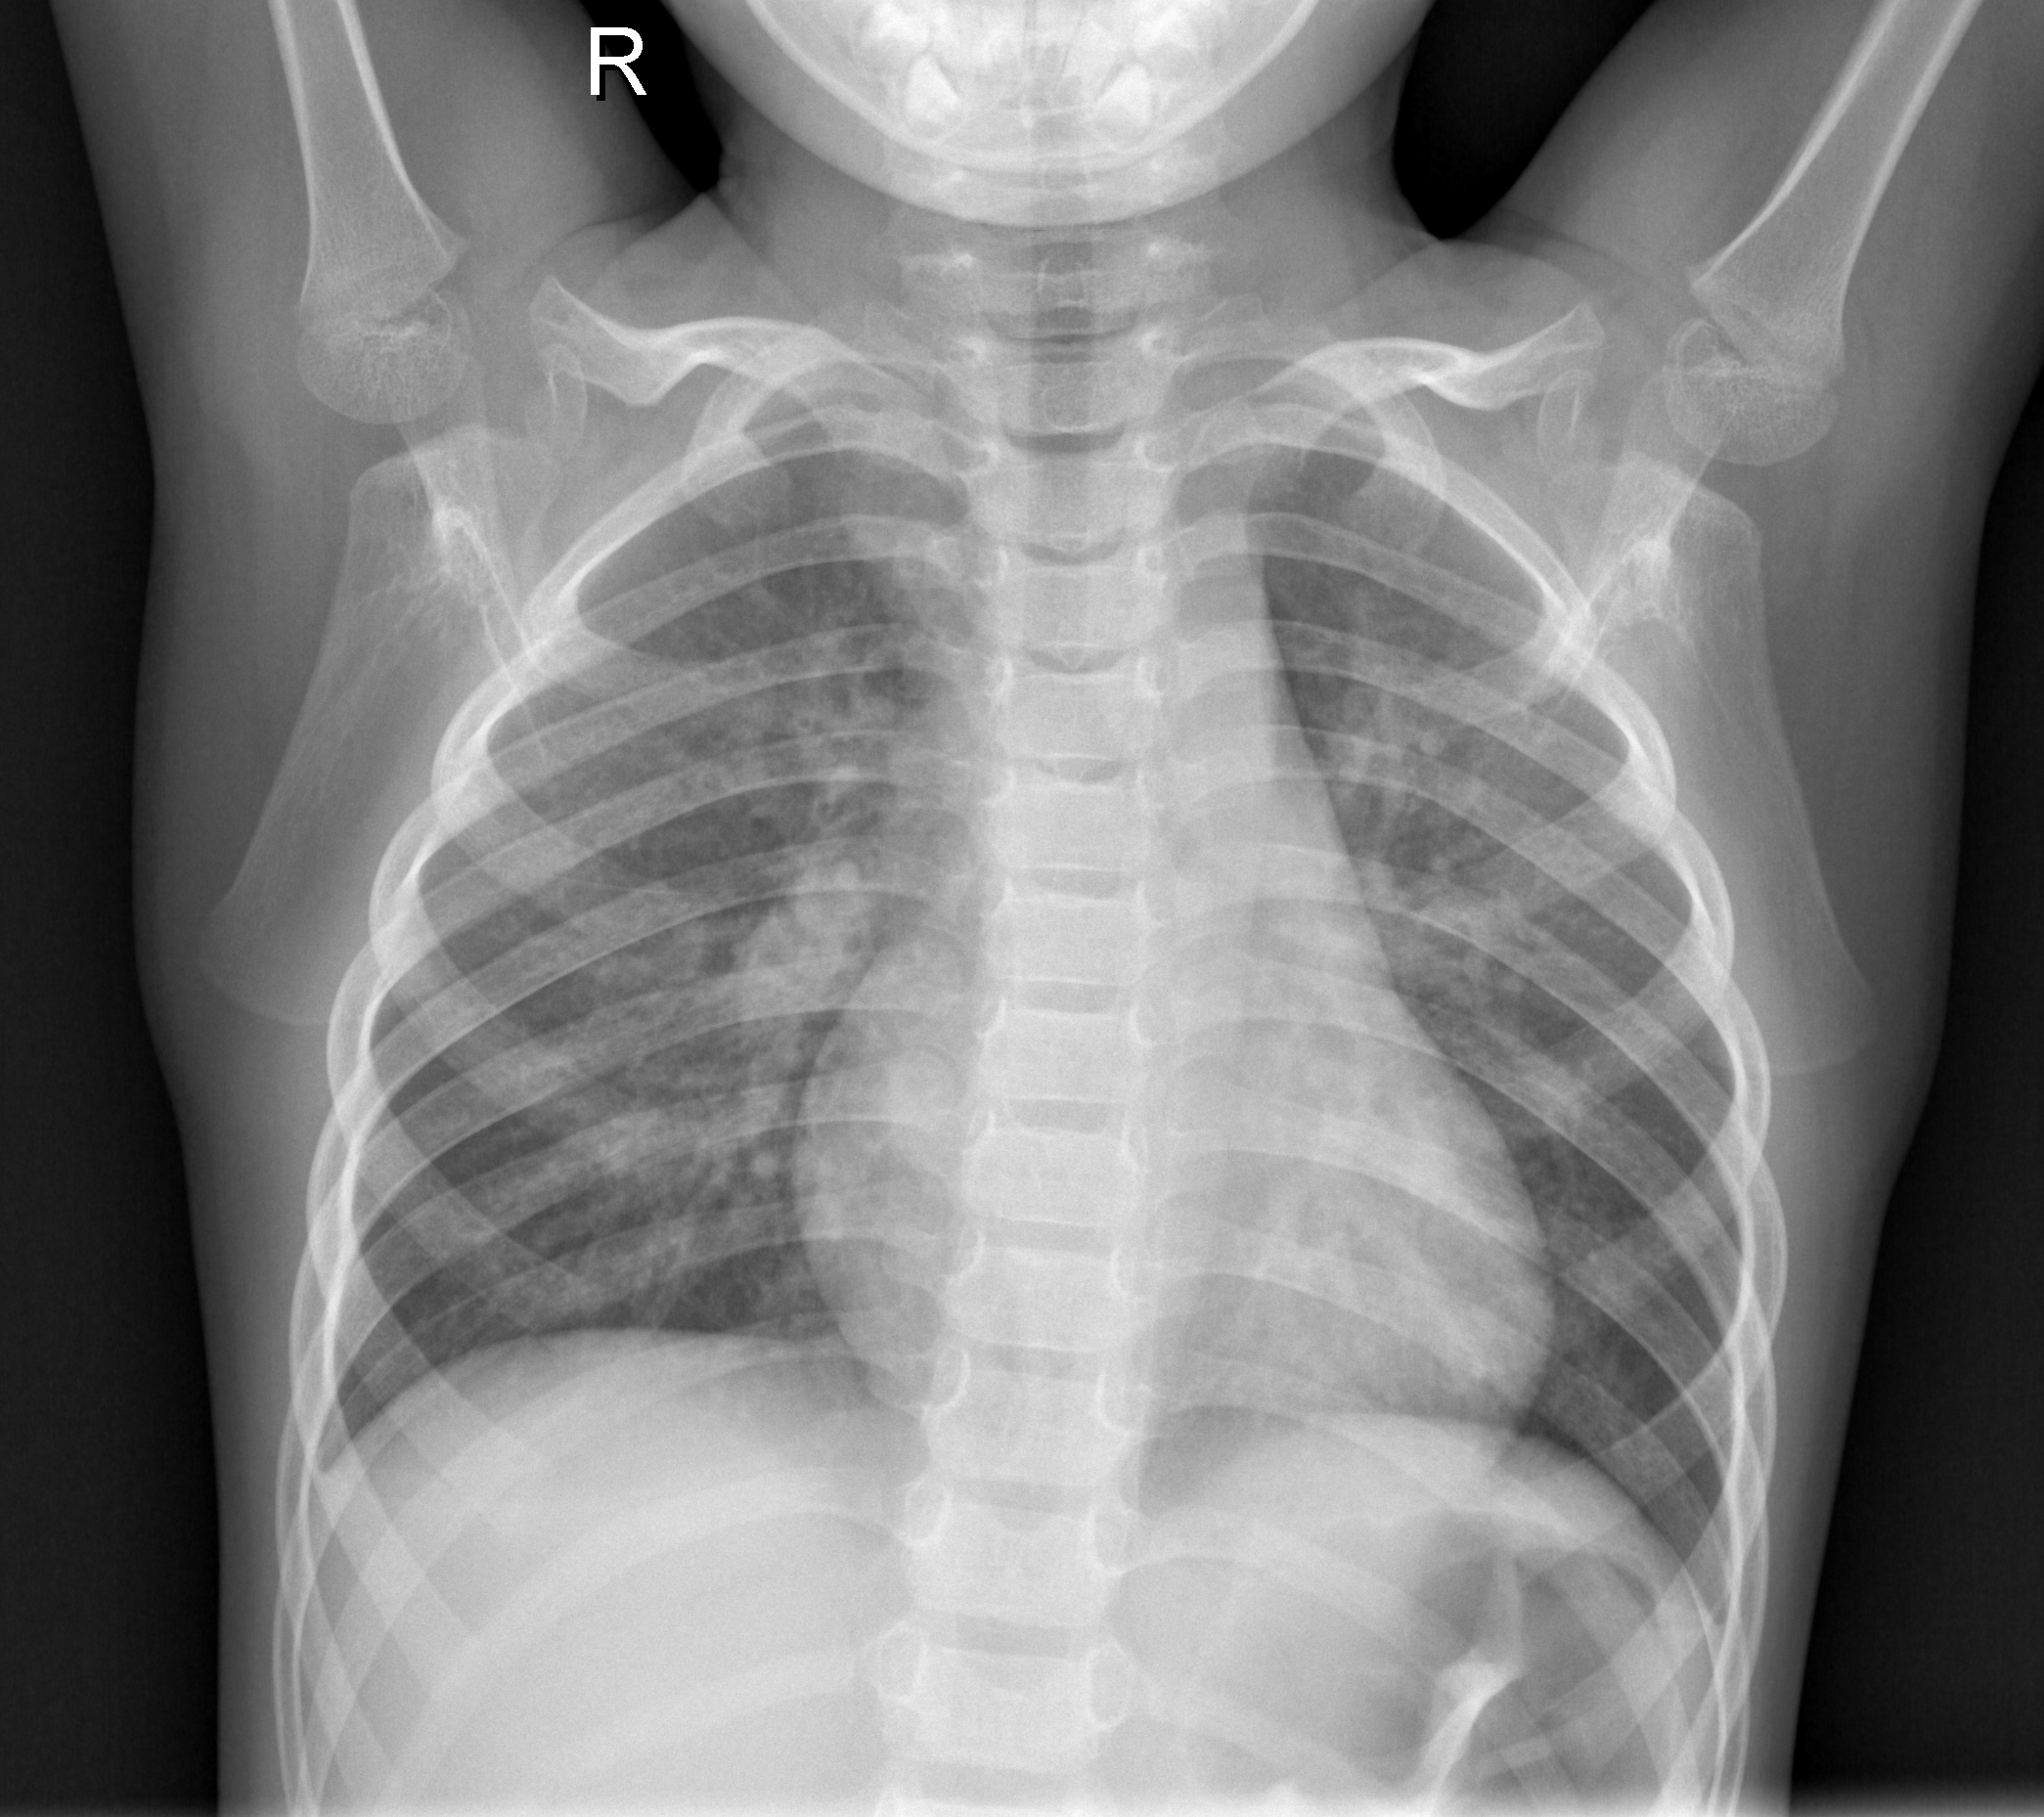

In [10]:
image = Image.open(path+"/train/NORMAL/IM-0115-0001.jpeg")
image

In [11]:
image.size

(2090, 1858)

In [12]:
train_dir = path+'/train'
test_dir = path+'/test'
val_dir = path+'/val'

In [13]:
def show_images(data_dir, label, num_images):
    images_path = glob(os.path.join(data_dir, label, '*jpeg'))
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        img = Image.open(images_path[i])
        plt.imshow(img, cmap='gray')
        title = label+'   image_size='+str(img.size)
        plt.title(title)
        plt.axis('off')
    plt.show()

# The images have different sizes****

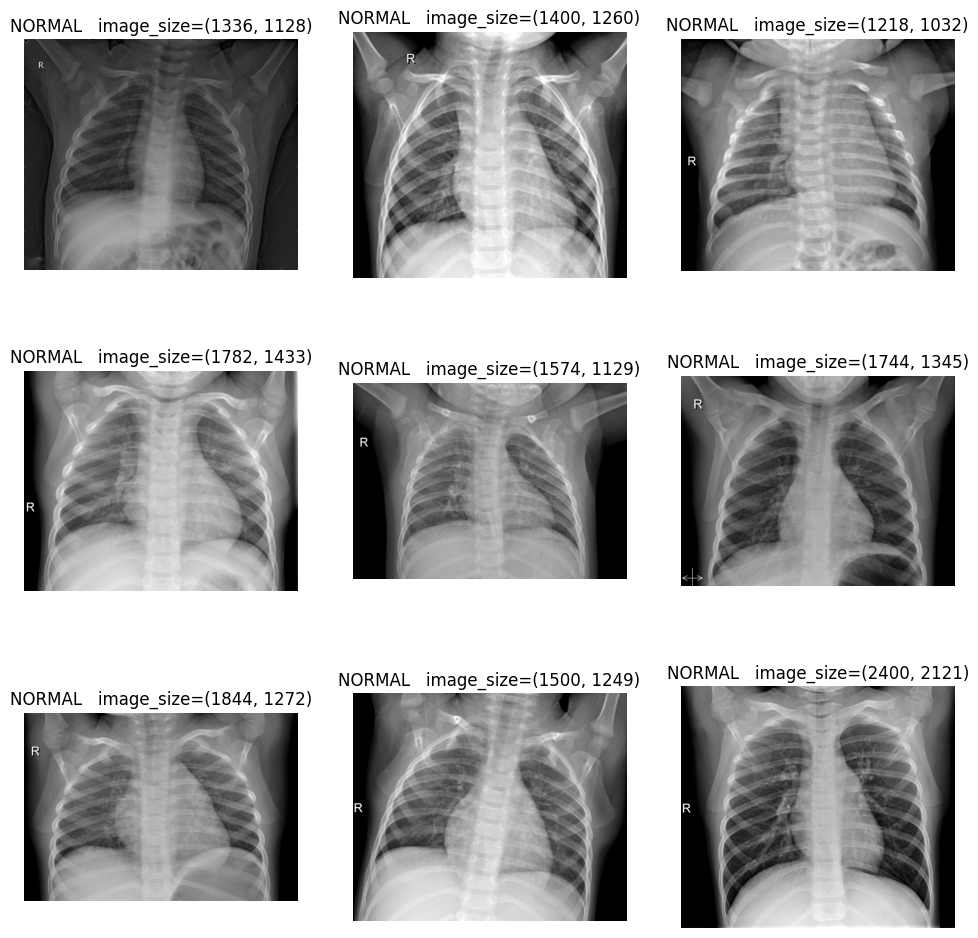

In [14]:
show_images(train_dir, 'NORMAL', 9)

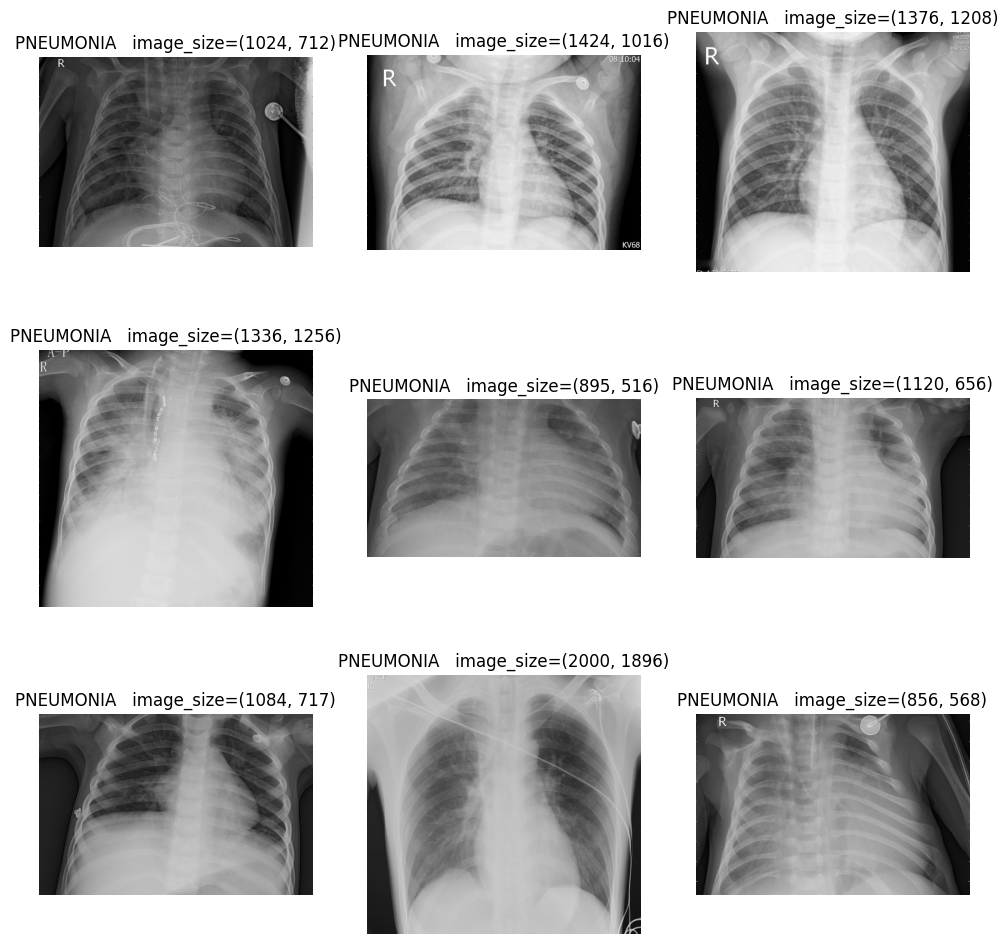

In [15]:
show_images(train_dir, 'PNEUMONIA', 9)

In [18]:
training_generator = ImageDataGenerator(rescale=1/255)
data_train = training_generator.flow_from_directory(train_dir, target_size=(200,200),batch_size=8, class_mode="binary", shuffle=True)

Found 5216 images belonging to 2 classes.


In [20]:
validation_generator = ImageDataGenerator(rescale=1/255)
data_valid = validation_generator.flow_from_directory(val_dir, target_size=(200,200),batch_size=8, class_mode="binary", shuffle=False)

Found 16 images belonging to 2 classes.


In [21]:
test_generator = ImageDataGenerator(rescale=1/255)
data_test = test_generator.flow_from_directory(test_dir, target_size=(200,200),batch_size=8, class_mode="binary", shuffle=False)

Found 624 images belonging to 2 classes.


In [22]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32,kernel_size=(3,3), input_shape=(200,200,3), activation="relu"))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(64,kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(128,kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(256,kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(512,kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))
    return model

In [23]:
model = create_model()
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,576,769 (6.01 MB)

 Trainable params: 1,576,769 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy",
             metrics=['accuracy'])

In [25]:
es = EarlyStopping(monitor='val_loss', patience = 5, mode='min', restore_best_weights= True)


In [26]:
class_labels = np.unique(data_train.classes)
class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(data_train.classes),y= data_train.classes)

In [27]:
class_weights

array([1.9448173 , 0.67303226])

In [28]:
class_weight_dict = dict(enumerate(class_weights))

In [30]:
history = model.fit(data_train, class_weight=class_weight_dict, epochs=40, validation_data=data_valid,
                             callbacks = [es])

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


652/652 ━━━━━━━━━━━━━━━━━━━━ 286s 433ms/step - accuracy: 0.7666 - loss: 0.5011 - val_accuracy: 0.7500 - val_loss: 0.7288
Epoch 2/40
652/652 ━━━━━━━━━━━━━━━━━━━━ 275s 420ms/step - accuracy: 0.9281 - loss: 0.1885 - val_accuracy: 0.9375 - val_loss: 0.1286
Epoch 3/40
652/652 ━━━━━━━━━━━━━━━━━━━━ 276s 422ms/step - accuracy: 0.9519 - loss: 0.1240 - val_accuracy: 0.9375 - val_loss: 0.1352
Epoch 4/40
652/652 ━━━━━━━━━━━━━━━━━━━━ 321s 421ms/step - accuracy: 0.9683 - loss: 0.0871 - val_accuracy: 0.6875 - val_loss: 1.0262
Epoch 5/40
652/652 ━━━━━━━━━━━━━━━━━━━━ 322s 421ms/step - accuracy: 0.9700 - loss: 0.0839 - val_accuracy: 1.0000 - val_loss: 0.0630
Epoch 6/40
652/652 ━━━━━━━━━━━━━━━━━━━━ 321s 420ms/step - accuracy: 0.9697 - loss: 0.0685 - val_accuracy: 0.8125 - val_loss: 0.2978
Epoch 7/40
652/652 ━━━━━━━━━━━━━━━━━━━━ 275s 420ms/step - accuracy: 0.9778 - loss: 0.0582 - val_accuracy: 1.0000 - val_loss: 0.0228
Epoch 8/40
652/652 ━━━━━━━━━━━━━━━━━━━━ 275s 420ms/step - accuracy: 0.9829 - loss: 0.03

In [31]:
result = model.evaluate(data_test)
print("Test Loss: ", result[0])
print("Test Accuracy: " ,result[1])

78/78 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.6023 - loss: 2.9415
Test Loss:  1.6337592601776123
Test Accuracy:  0.7852563858032227


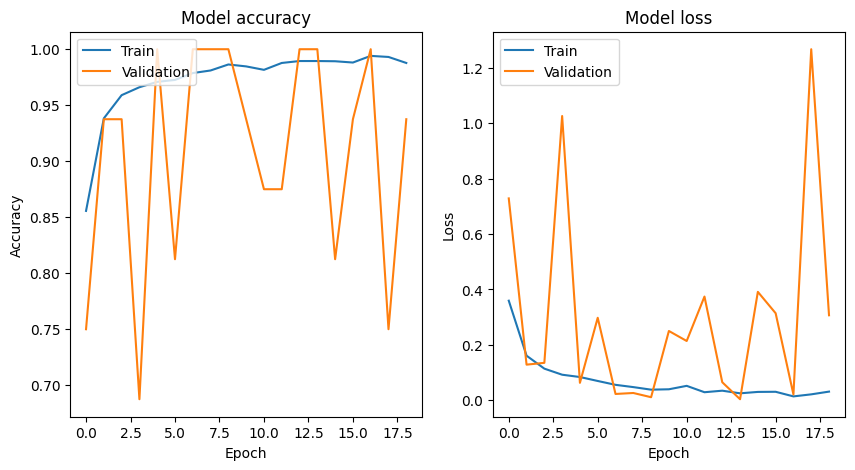

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# Plot the training and validation accuracy
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot the training and validation loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

# Display the plots
plt.show()

In [33]:
y_pred = model.predict(data_test)

78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step


In [34]:
y_pred_bin = np.squeeze(np.round(y_pred))
print(classification_report(data_test.classes, y_pred_bin))

              precision    recall  f1-score   support

           0       0.97      0.44      0.61       234
           1       0.75      0.99      0.85       390

    accuracy                           0.79       624
   macro avg       0.86      0.72      0.73       624
weighted avg       0.83      0.79      0.76       624



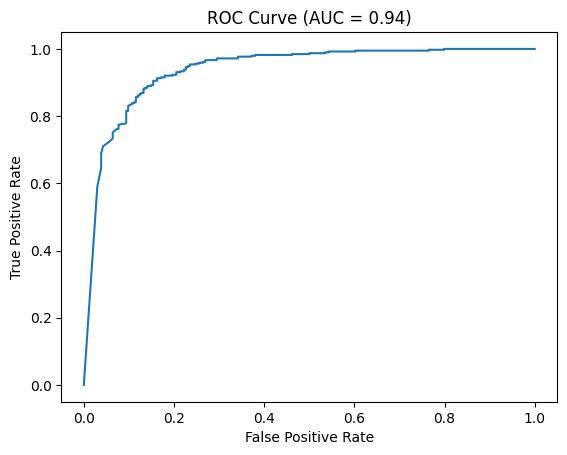

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(data_test.classes, y_pred)
auc_score = roc_auc_score(data_test.classes, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {auc_score:.2f})')
plt.show()